### Mounting drive on Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


###Libraries

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 29.7 MB/s 


In [3]:
import os
import cv2
import os
import h5py
import numpy as np
import pickle
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
os.chdir('/gdrive/My Drive/')
from numpy import savez_compressed
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow_datasets as tfds
from tensorflow_addons.metrics import HammingLoss
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

## Baseline Models

### Testing Baseline model with Imagenet as a source

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

pre_trained_model = ResNet50(input_shape = (96, 96, 3), 
                                include_top = False, 
                                weights = None)
for layer in pre_trained_model.layers:
  layer.trainable = False

In [6]:
def compile_model():
  from tensorflow.keras.optimizers import RMSprop

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(pre_trained_model.output)
  # Add a fully connected layer with 2000 hidden units and ReLU activation
  x = layers.Dense(2000, activation='relu')(x)
  # Add a fully connected layer with 2000 hidden units and ReLU activation
  x = layers.Dense(1000, activation='relu')(x)
  # Add a fully connected layer with 2000 hidden units and ReLU activation
  x = layers.Dense(500, activation='relu')(x)                  
  # Add a final softmax layer for classification
  x = layers.Dense  (15, activation='softmax')(x)           

  model = Model( pre_trained_model.input, x) 

  model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), HammingLoss(threshold=0.5, mode='multiclass'), F1Score(num_classes= 15, threshold=0.5)])
  return model

In [7]:
data = np.load('Xtrain.npy', allow_pickle=True)
labels = np.load('ytrain.npy', allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

In [8]:
y_train = to_categorical(y_train, 15)
y_val = to_categorical(y_val, 15)
y_test = to_categorical(y_test, 15)

In [9]:
imagenet_resnet50 = compile_model()
history = imagenet_resnet50.fit(X_train, y_train, batch_size = 200, epochs=15, validation_data=(X_val, y_val), callbacks = [cb])
print(cb.logs)
print(sum(cb.logs))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/15
120/120 [==============================] - 35s 172ms/step - loss: 10.8048 - acc: 0.0673 - auc: 0.5015 - recall: 0.0341 - precision: 0.0663 - hamming_loss: 0.9659 - f1_score: 0.0444 - val_loss: 4.2250 - val_acc: 0.0660 - val_auc: 0.5015 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_hamming_loss: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/15
120/120 [==============================] - 19s 161ms/step - loss: 3.2028 - acc: 0.0686 - auc: 0.5021 - recall: 0.0022 - precision: 0.0758 - hamming_loss: 0.9978 - f1_score: 0.0041 - val_loss: 2.7949 - val_acc: 0.0667 - val_auc: 0.5121 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_hamming_loss: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/15
120/120 [==============================] - 20s 163ms/step - loss: 2.8018 - acc: 0.0713 - auc: 0.5073 - recall: 0.0000e+00 - precision: 0.0000e+00 - hamming_loss: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.7155 - val_acc: 0.0807 - val_auc: 0.5148 - val_recall: 0.0000e+00 - val_prec

In [10]:
imagenet_resnet50.save('/gdrive/My Drive/MLresnet50.h5')

Text(0.5, 0, 'epoch')

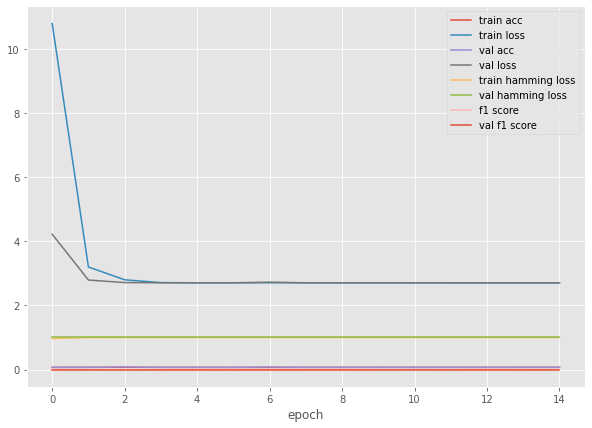

In [11]:
plt.style.use(['ggplot'])
plt.figure(figsize=(10, 7))

plt.plot(history.history['acc'], label = 'train acc')
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.plot(history.history['hamming_loss'], label = 'train hamming loss')
plt.plot(history.history['val_hamming_loss'], label = 'val hamming loss')
plt.plot(sum(history.history['f1_score'])/15, label = 'f1 score')
plt.plot(sum(history.history['val_f1_score'])/15, label = 'val f1 score')

plt.legend()

plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

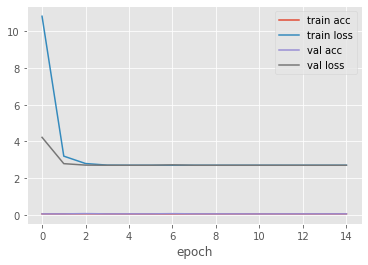

In [12]:
plt.style.use(['ggplot'])

plt.plot(history.history['acc'], label = 'train acc')
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['val_loss'], label = 'val loss')

plt.legend()

plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

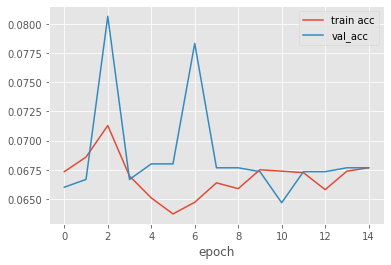

In [13]:
plt.style.use(['ggplot'])

plt.plot(history.history['acc'], label = 'train acc')
plt.plot(history.history['val_acc'], label = 'val_acc')

plt.legend()

plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

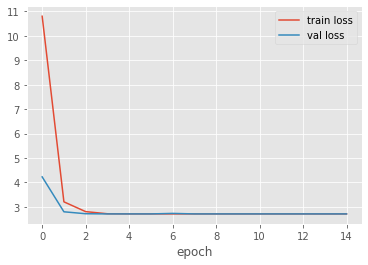

In [14]:
plt.style.use(['ggplot'])
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

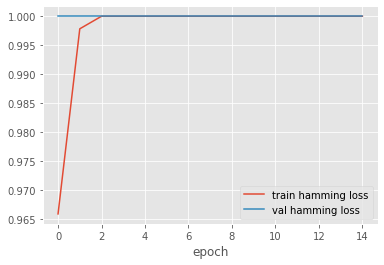

In [15]:
plt.style.use(['ggplot'])
plt.plot(history.history['hamming_loss'], label = 'train hamming loss')
plt.plot(history.history['val_hamming_loss'], label = 'val hamming loss')
plt.legend()
plt.xlabel('epoch')

In [16]:
score = imagenet_resnet50.evaluate(X_test, y_test, verbose=0)
print(score)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])
print('ROC-AUC', score[2])
print('Recall', score[3])
print('Precision', score[4])
print('Hamming Loss', score[5])
print('F1 Score', sum(score[6])/15)

[2.708035707473755, 0.06733333319425583, 0.500083327293396, 0.0, 0.0, 1.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)]
Test Loss: 2.708035707473755
Test Accuracy: 0.06733333319425583
ROC-AUC 0.500083327293396
Recall 0.0
Precision 0.0
Hamming Loss 1.0
F1 Score 0.0


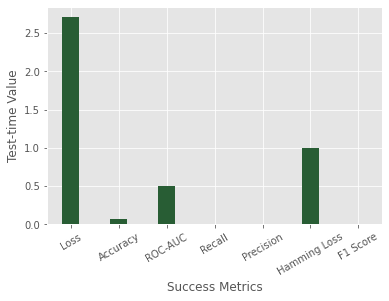

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

labels = ['Loss', 'Accuracy', 'ROC-AUC', 'Recall', 'Precision', 'Hamming Loss', 'F1 Score']

acc_imagenet = [score[0], score[1], score[2], score[3], score[4], score[5], sum(score[6])/15]

width = 0.35 

fig, ax = plt.subplots()

ax.bar(labels, acc_imagenet, width, label='ImageNet', color = '#285D34')

ax.set_xlabel('Success Metrics')
ax.set_ylabel('Test-time Value')
plt.xticks(rotation=30)
plt.show()